In [1]:
import torchvision
import torchvision.transforms as transforms
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import time
from d2l import torch as d2l
# 定义训练的设备
device = torch.device("cuda:0")

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:

trainset = torchvision.datasets.CIFAR10(root='../2024_4_1pytorch时钟/data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='../2024_4_1pytorch时钟/data', train=False,
                                       download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# 训练集和测试集的长度
trainset_size = len(trainset)
testset_size = len(testset)
print("训练集的个数",trainset_size)
print("测试集的个数",testset_size)

训练集的个数 50000
测试集的个数 10000


In [5]:
batch_size = 50
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

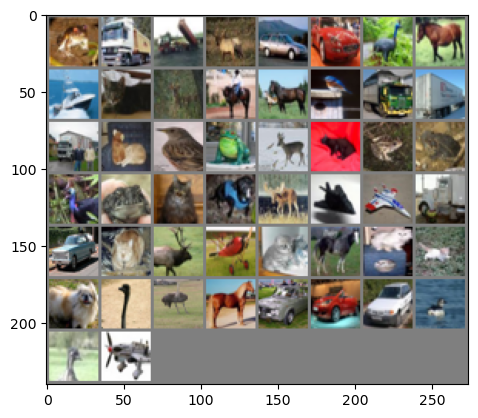

frog  truck truck deer  car   car   bird  horse ship  cat   deer  horse horse bird  truck truck truck cat   bird  frog  deer  cat   frog  frog  bird  frog  cat   dog   deer  plane plane truck car   cat   deer  plane cat   horse cat   cat   dog   bird  bird  horse car   car   car   bird  bird  plane


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    # img = img / 2 + 0.5: 这行代码对输入的图像数据进行反归一化操作。在训练过程中，图像数据通常被归一化到 [0, 1] 的范围内。这行代码将图像数据乘以0.5然后加上0.5，将其反归一化回原始的 [0, 1] 范围内。
    img = img / 2 + 0.5     # unnormalize
    #npimg = img.numpy(): 这行代码将 PyTorch 张量 img 转换为 NumPy 数组 npimg。这样做是因为 Matplotlib 库通常使用 NumPy 数组来处理图像数据。
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
# 获取一个批次的数据，也就是4张图片
#将训练数据加载器 trainloader 转换为一个迭代器 dataiter
dataiter = iter(trainloader)
# 使用 next() 函数逐个获取数据批次。
images, labels = next(dataiter) 


# show images
#torchvision.utils.make_grid(images): 这个函数会将图像张量 images 中的多个图像按照网格排列，并返回一个包含这些图像的网格图像张量。
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [7]:
# 构建网络
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.model = nn.Sequential(
        nn.Conv2d(3, 6, kernel_size=5, padding=2), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
        nn.AvgPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 6 * 6, 120), nn.Sigmoid(),
        nn.Linear(120, 84), nn.Sigmoid(),
        nn.Linear(84, 10)
        
        )
    def forward(self,inputs):
        output = self.model(inputs)
        return output

In [8]:
net = Net()
net = net.to(device)
print(net)

Net(
  (model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Sigmoid()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Sigmoid()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=576, out_features=120, bias=True)
    (8): Sigmoid()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): Sigmoid()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [ ]:
# 查看数据集
for data in trainloader:
    inputs,targets = data
    print(targets)
    print(inputs.shape)

In [9]:
# 查看每层的输出
X = torch.rand(size=(1, 3, 32, 32), dtype=torch.float32)
X = X.to(device)
for layer in net.model:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 6, 32, 32])
Sigmoid output shape: 	 torch.Size([1, 6, 32, 32])
AvgPool2d output shape: 	 torch.Size([1, 6, 16, 16])
Conv2d output shape: 	 torch.Size([1, 16, 12, 12])
Sigmoid output shape: 	 torch.Size([1, 16, 12, 12])
AvgPool2d output shape: 	 torch.Size([1, 16, 6, 6])
Flatten output shape: 	 torch.Size([1, 576])
Linear output shape: 	 torch.Size([1, 120])
Sigmoid output shape: 	 torch.Size([1, 120])
Linear output shape: 	 torch.Size([1, 84])
Sigmoid output shape: 	 torch.Size([1, 84])
Linear output shape: 	 torch.Size([1, 10])


模型已保存


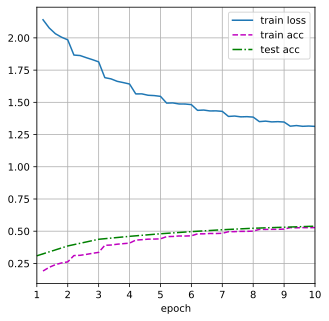

In [10]:
# 损失函数
loss = nn.CrossEntropyLoss()
loss = loss.to(device)
# 设置优化器
learning_rate = 0.001
optimter = optim.RMSprop(net.parameters(),lr=learning_rate)
# 设置训练次数
train_step = 0
# 设置训练次数
test_step = 0
# 训练次数
epochs = 10
animator = d2l.Animator(xlabel='epoch', xlim=[1, epochs],
                    legend=['train loss', 'train acc', 'test acc'],figsize=(5,5))
# 训练的批次总数
num_batches = len(trainloader)
# 训练10次
for epoch in range(1,epochs+1):
    # 每一轮训练损失之和，训练准确率之和，样本数
    metric = d2l.Accumulator(3)
    #  开始训练
    start_time = time.time()
    net.train()
    i = 0
    for data in trainloader:
        
        inputs,targets = data
        inputs = inputs.to(device)
        targets = targets.to(device)
        output = net(inputs)
        result_loss = loss(output,targets)
        # 把可调节参数的梯度调为0
        optimter.zero_grad()
        # 获取每个结点梯度的参数
        result_loss.backward()
        # 优化器调优
        optimter.step()
        train_step+=1
        if train_step%500==0:
            end_time = time.time()
            print("第{}轮训练500次时，花费的时间为:{}".format(epoch,end_time - start_time))
            print("训练次数：{}，Loss:{}".format(train_step,result_loss.item()))
            
        with torch.no_grad():
            metric.add(result_loss * inputs.shape[0], d2l.accuracy(output, targets), inputs.shape[0])
        # 训练总损失
        train_l = metric[0] / metric[2]
        #  训练总精度
        train_acc = metric[1] / metric[2]
        if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                # 每一轮更新5次可视化或者每一轮结束时都会更新一次可视化。
                # epoch + (i + 1) / num_batches相当于给x轴赋值
                # 同理 其他三个相当于给y轴赋值
                animator.add(epoch + (i + 1) / num_batches,
                            (train_l, train_acc, None))
        i+=1
        
    print("第{}次训练结束".format(epoch))
    with torch.no_grad():
        # 测试的准确率
        total_accuracy = 0
        runing_loss = 0
        # 测试步骤开始
        net.eval()
        for test in testloader:
            test_step+=1
            inputs,targets = test
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = net(inputs)
            result_loss = loss(output,targets)
            runing_loss+=result_loss.item()
            accuracy = (output.argmax(1) == targets).sum()
            total_accuracy +=accuracy
    # print("每{}轮测试集上的损失Loss:{}".format(epoch,runing_loss))
    # print("每{}轮测试集上的正确率:{}".format(epoch,total_accuracy/testset_size))
    total_accuracy_cpu = total_accuracy.cpu().numpy()
    # testset_size_cpu = testset_size.cpu().numpy()
    animator.add(epoch,(None, None, total_accuracy_cpu/testset_size))
    
    # 模型保存
    torch.save(net,"./model3_{}.pth".format(epoch))
    print("模型已保存")

In [ ]:
print("训练集上的损失:{}".format(train_l))
print("训练集上的正确率:{}".format( train_acc))
print("测试集上的正确率:{}".format(total_accuracy_cpu/testset_size))


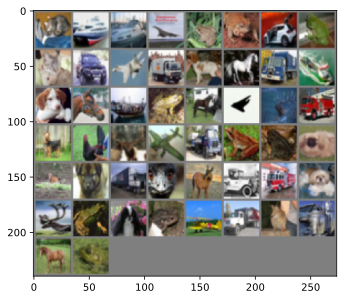

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog   deer  dog   truck bird  deer  car   truck dog   deer  frog  dog   frog  plane truck cat   truck horse frog 


In [11]:
# 在测试数据上测试网络
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(50)))

In [16]:
# 加载模型
net = Net()
model = torch.load("./model3_10.pth",map_location=torch.device("cpu"))
images = torch.reshape(images,(50,3,32,32))
outputs = model(images)
_, predicted = torch.max(outputs, 1)
# 上面图片预测的结果为
print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(50)))

Predicted:  cat   car   car   ship  frog  frog  cat   frog  dog   car   plane car   dog   horse car   ship  dog   truck ship  horse horse plane plane truck deer  frog  frog  bird  truck frog  frog  deer  deer  cat   truck cat   frog  truck truck dog   horse frog  dog   frog  plane truck cat   truck horse deer 


In [30]:
# 自己找图片
import torch
import torchvision
from PIL import Image
from torch import nn

image_path = "../image/img_6.png"
image = Image.open(image_path)
# print(image)
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((32,32)),
    torchvision.transforms.ToTensor()
])
image = transform(image)

In [31]:
image = torch.reshape(image,(1,3,32,32))
model.eval()
with torch.no_grad():
    output = model(image)
print(output)
print(output.argmax(1))

tensor([[ 0.3468,  0.5432, -1.7403, -1.1499, -2.0955, -1.3817, -4.1952, -1.3997,
         -0.3169, -0.0245]])
tensor([1])


In [ ]:
nn.Sequential()